# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 1. Introducción</p>

En este proyecto, se llevará a cabo un análisis de una base de datos que contiene registros de los niveles de polución (PM2.5) durante cuatro años, complementados con variables climáticas como temperatura, presión y velocidad del viento. El objetivo es desarrollar un algoritmo predictivo capaz de estimar los niveles futuros de PM2.5 utilizando algoritmos de ML y DL. Para lograr esto, se realizará primero una limpieza y un preprocesamiento de los datos, lo que incluye el manejo de valores nulos y la preparación del conjunto de datos para el modelado.


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

import warnings
warnings.filterwarnings('ignore')

In [47]:
df = pd.read_csv('data.txt')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [48]:
df.drop('No', axis=1, inplace=True)
df

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 2. Interpretación de la información</p>


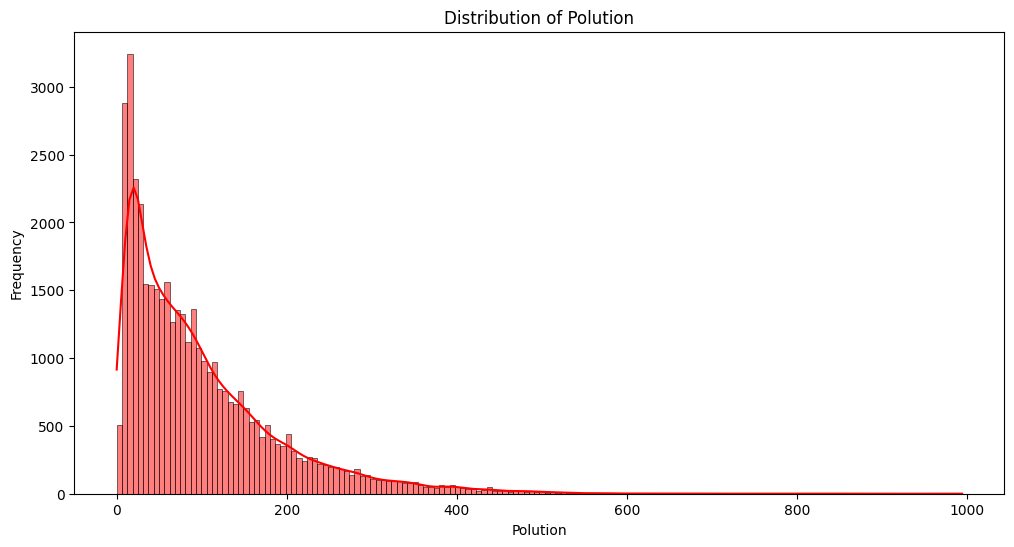

count    41757.000000
mean        98.613215
std         92.050387
min          0.000000
25%         29.000000
50%         72.000000
75%        137.000000
max        994.000000
Name: pm2.5, dtype: float64

In [49]:
def distribution(df):
    polution = df['pm2.5']
    plt.figure(figsize=(12, 6))
    sns.histplot(polution, kde=True, color='r')
    plt.title('Distribution of Polution')
    plt.xlabel('Polution')
    plt.ylabel('Frequency')
    plt.show()
    return polution.describe()
distribution(df)

Se observa una **distribución asimétrica** con una **cola larga hacia la derecha**. La mayoría de los valores de polución están concentrados en niveles bajos, entre **0 y 200**, con una frecuencia que disminuye gradualmente a medida que aumenta el nivel de polución.


In [50]:
def null_pertenages(df):
    null_percentages = df.isnull().mean().mul(100).round(2)

    null_percentage_table = pd.DataFrame({
        'Column': null_percentages.index,
        'Null Percentage (%)': null_percentages.values
    })
    return null_percentage_table
null_pertenages(df)

,Column,Null Percentage (%)
0,year,0.00
1,month,0.00
2,day,0.00
3,hour,0.00
4,pm2.5,4.72
5,DEWP,0.00
6,TEMP,0.00
7,PRES,0.00
8,cbwd,0.00
9,Iws,0.00


Según el análisis de la base de datos, aproximadamente el 5% de los registros de polución carecen de valores definidos en diferentes horas del día. Para preservar la integridad de los datos, agruparemos la información por hora y calcularemos la media de concentración de pm2.5 para cada franja horaria. Luego, utilizaremos esta media para reemplazar los valores nulos, manteniendo el patrón temporal y asegurando la coherencia de los datos.


In [51]:
data = df.copy()
def process_null_values(df):
    hourly_mean_pm25 = data.groupby('hour')['pm2.5'].transform('mean').round(2)
    data['pm2.5'] = data['pm2.5'].fillna(hourly_mean_pm25)

    null_percentages = data.isnull().mean().mul(100).round(2)

    null_percentage_table = pd.DataFrame({
        'Column': null_percentages.index,
        'Null Percentage (%)': null_percentages.values
    })
    return null_percentage_table
process_null_values(data)

,Column,Null Percentage (%)
0,year,0.0
1,month,0.0
2,day,0.0
3,hour,0.0
4,pm2.5,0.0
5,DEWP,0.0
6,TEMP,0.0
7,PRES,0.0
8,cbwd,0.0
9,Iws,0.0


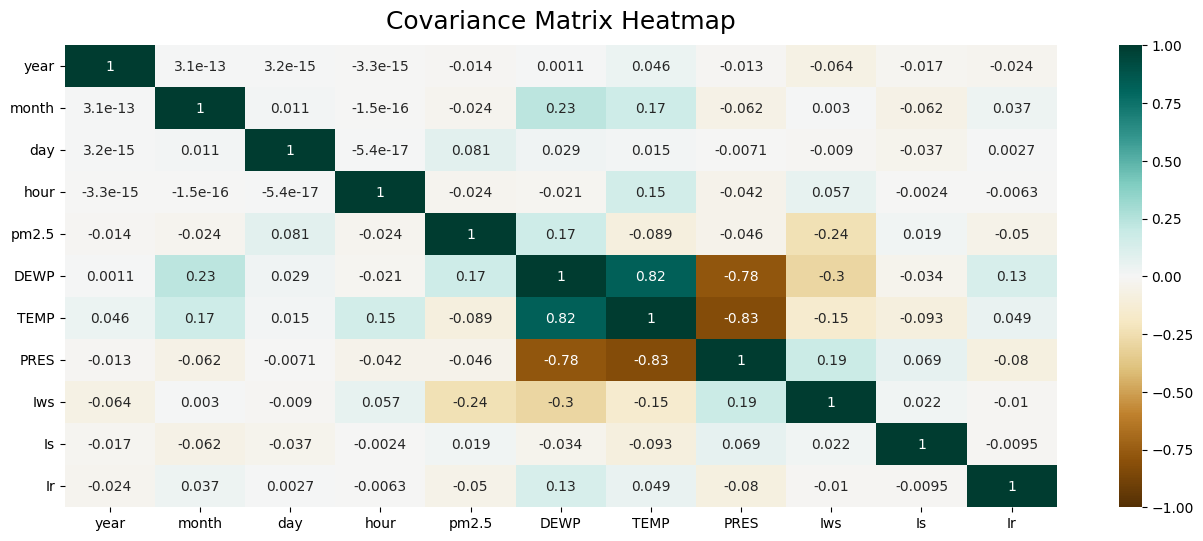

In [52]:
def covariance_heatmap(df):
    data_num = data.drop(data.select_dtypes(include=['object']).columns,axis=1)
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(data_num.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Covariance Matrix Heatmap', fontdict={'fontsize':18}, pad=12);
covariance_heatmap(data)

La matriz de covarianza revela las relaciones más importantes entre las variables climáticas y la concentración de PM2.5:

- DEWP y TEMP tienen una fuerte correlación positiva (0.82), indicando que a mayor temperatura, también aumenta el punto de rocío.
- PRES y TEMP (-0.83) y PRES y DEWP (-0.78) muestran correlaciones negativas, sugiriendo que, en condiciones más cálidas y húmedas, la presión atmosférica disminuye.
- Is (horas acumuladas de nieve) tiene una correlación negativa moderada con PM2.5 (-0.24), indicando que la nieve reduce los niveles de contaminación.

En resumen, la humedad y la temperatura influyen fuertemente en la presión, mientras que la nieve actúa como un agente limpiador que disminuye la polución.


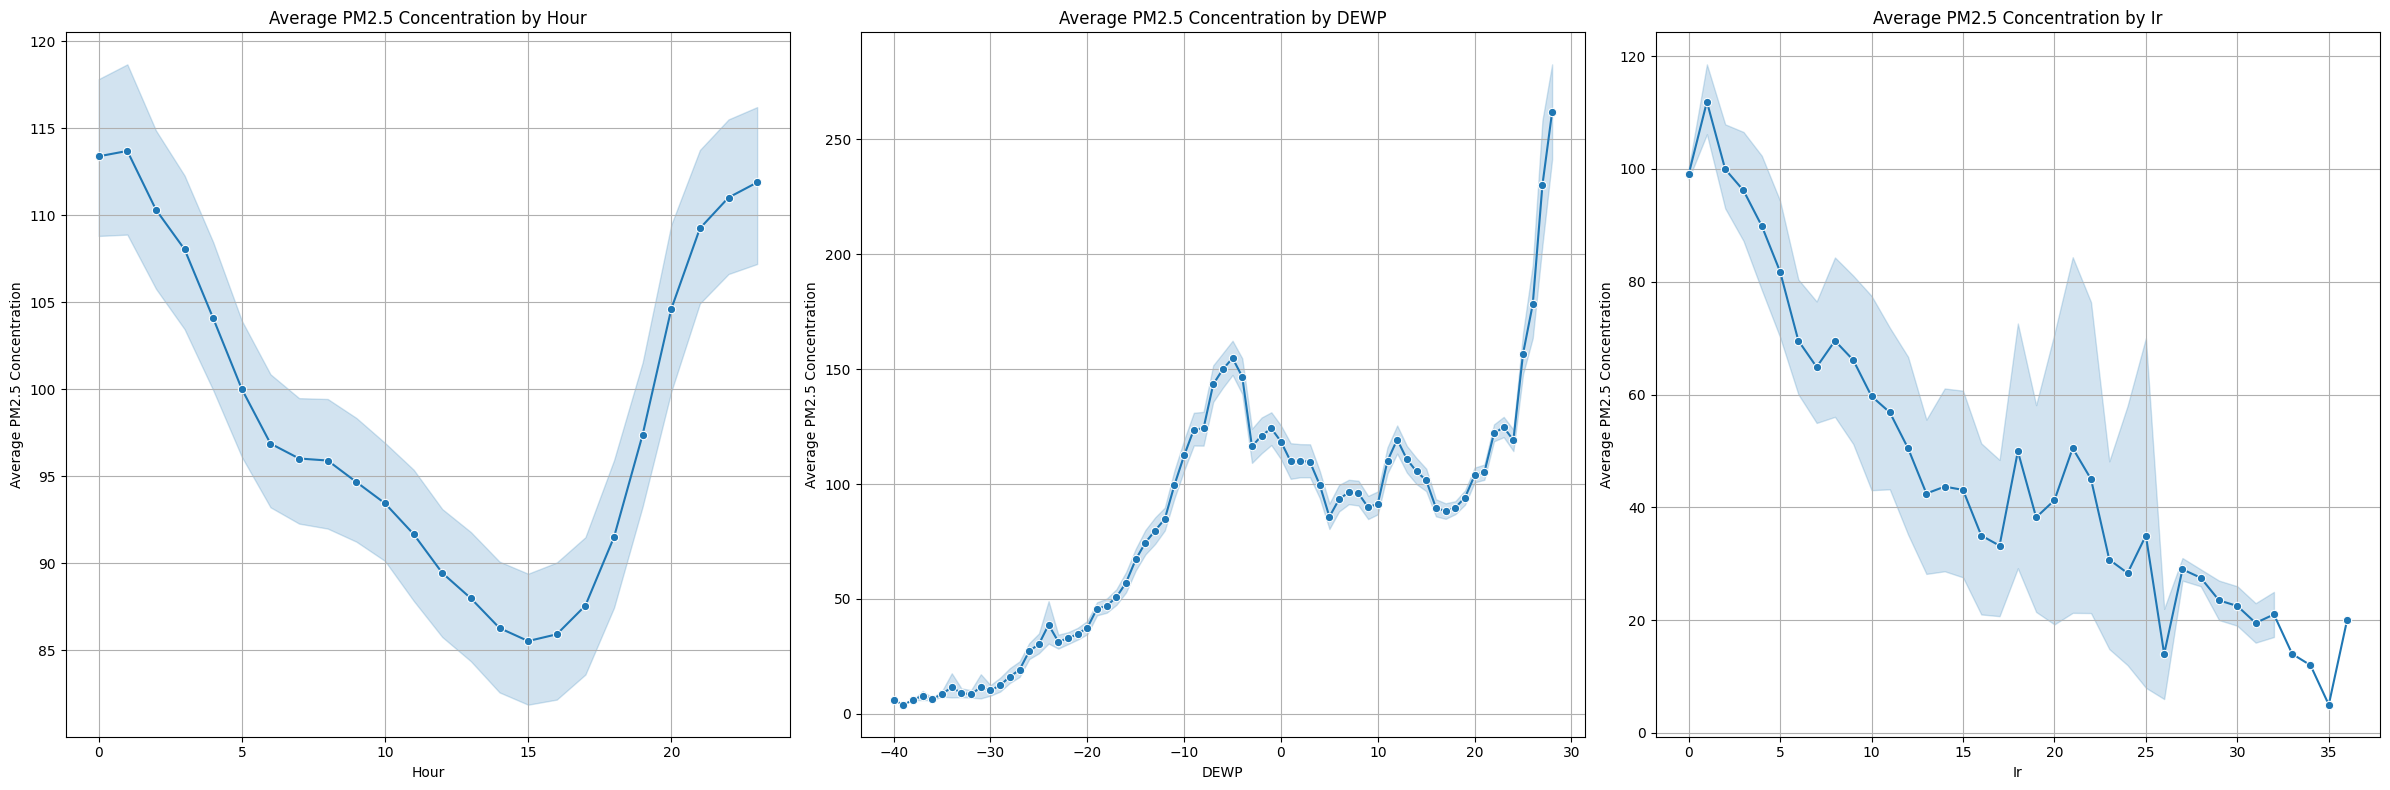

In [10]:
def plot_pm25(df):
# Se puede añadir más gráficos si es necesario, sin embargo, para este caso se utilizaron los mas relevantes para el análisis.
    plot_params = [
        {'x': 'hour', 'y': 'pm2.5', 'title': 'Average PM2.5 Concentration by Hour', 'xlabel': 'Hour'},
        {'x': 'DEWP', 'y': 'pm2.5', 'title': 'Average PM2.5 Concentration by DEWP', 'xlabel': 'DEWP'},
        {'x': 'Ir', 'y': 'pm2.5', 'title': 'Average PM2.5 Concentration by Ir', 'xlabel': 'Ir'},
    ]

    fig, axes = plt.subplots(1, len(plot_params), figsize=(8*len(plot_params), 8))

    for i, params in enumerate(plot_params):
        sns.lineplot(ax=axes[i], x=params['x'], y=params['y'], data=data, marker='o')
        axes[i].set_title(params['title'])
        axes[i].set_xlabel(params['xlabel'])
        axes[i].set_ylabel('Average PM2.5 Concentration')
        axes[i].grid(True)

    plt.tight_layout()
plot_pm25(data)

La gráfica muestra el comportamiento de la concentración promedio de PM2.5 a lo largo del día, revelando un patrón cíclico con picos y descensos bien definidos. Durante el rango horario nocturno, desde las 7:00 PM hasta las 5:00 AM, la concentración de PM2.5 es alta, alcanzando valores cercanos a 115, lo que indica un aumento de la polución en este periodo.

Este comportamiento sugiere que hay momentos del día en los que la calidad del aire empeora notablemente. El incremento nocturno de la concentración de PM2.5 podría estar relacionado con factores como la menor circulación de aire, el aumento de la actividad industrial, y la acumulación de contaminantes.

La disminución observada durante la mañana y el mediodía podría deberse a una mayor actividad atmosférica y a la ventilación natural del aire. La variabilidad observada, con intervalos de confianza más amplios en la madrugada y la tarde, podría reflejar fluctuaciones en los niveles de polución debido al tráfico o a cambios en las condiciones meteorológicas.

Por otra parte, a medida que el punto de rocío (DEWP) aumenta, la concentración de PM2.5 también tiende a incrementarse. Además, a partir de DEWP = 20, se observa un aumento abrupto en la concentración de PM2.5, que alcanza valores superiores a 250, lo que sugiere que cuando hay mayor humedad en el aire, la polución tiende a empeorar significativamente.

Finalmente, la tercera gráfica sugiere que, a medida que aumentan las horas acumuladas de nieve, la concentración de PM2.5 tiende a disminuir. La nieve actúa como un agente de limpieza del aire, atrapando partículas contaminantes y eliminándolas del ambiente.


In [11]:
data.to_csv('dm.txt', sep=',', index=False)

Guardamos nuestra nueva base de datos con los cambios realizados en los procesos anteriores.


# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 3. ML para la predicción de Polución</p>

Para el desarrollo de este ejercicio, se utilizarán dos tipos de modelos de regresión. Dependiendo de los resultados obtenidos, seleccionaremos el modelo más adecuado para, posteriormente, integrarlo en una aplicación con Streamlit, facilitando así su uso.

El primer modelo es el **RandomForestRegressor**, elegido debido a su capacidad para evitar el overfitting durante el entrenamiento. Además, maneja bien características no lineales, es más tolerante al ruido y a valores atípicos, y ofrece un buen rendimiento con un costo computacional relativamente bajo.

El segundo modelo seleccionado es una **Deep Neural Network** con varias capas que utilizan la función de activación “relu”. Este modelo fue elegido porque, al igual que el **RandomForestRegressor**, es efectivo en el manejo de relaciones no lineales. Además, destaca por su escalabilidad a grandes volúmenes de datos, su alto nivel de personalización y su mayor potencial para generalizar en nuevos conjuntos de datos.


In [12]:
def process_cbwd_column(df, use_mapping=True, use_dummies=False):
    if use_mapping and use_dummies:
        raise ValueError("Solo puedes usar 'use_mapping' o 'use_dummies', no ambos al mismo tiempo.")
    
    # Mapeo de valores para la columna 'cbwd'
    cbwd_mapping = {'NW': 0, 'cv': 1, 'NE': 2, 'SE': 3}
    
    # Aplicar el mapeo si use_mapping es True
    if use_mapping:
        df['cbwd'] = df['cbwd'].map(cbwd_mapping)
    
    # Si use_dummies es True, crear variables dummy
    elif use_dummies:
        df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)
    
    return df

process_cbwd_column(data, use_mapping=True, use_dummies=False)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010,1,1,0,113.39,-21,-11.0,1021.0,0,1.79,0,0
1,2010,1,1,1,113.70,-21,-12.0,1020.0,0,4.92,0,0
2,2010,1,1,2,110.32,-21,-11.0,1019.0,0,6.71,0,0
3,2010,1,1,3,108.04,-21,-14.0,1019.0,0,9.84,0,0
4,2010,1,1,4,104.08,-20,-12.0,1018.0,0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.00,-23,-2.0,1034.0,0,231.97,0,0
43820,2014,12,31,20,10.00,-22,-3.0,1034.0,0,237.78,0,0
43821,2014,12,31,21,10.00,-22,-3.0,1034.0,0,242.70,0,0
43822,2014,12,31,22,8.00,-22,-4.0,1034.0,0,246.72,0,0


In [13]:
data['cbwd'].unique()

array([0, 1, 2, 3])

In [14]:
X = data.drop('pm2.5', axis=1)
y = data['pm2.5']

In [30]:
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_random_forest(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf_model = RandomForestRegressor(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=50, cv=3, verbose=0, random_state=42, n_jobs=-1)
    
    rf_random.fit(X_train, y_train)
    print(f"Mejores hiperparámetros: {rf_random.best_params_}")
    
    return rf_random.best_estimator_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Random Forest - MSE: {mse}')
    print(f'Random Forest - RMSE: {rmse}')
    print(f'Random Forest - MAE: {mae}')
    print(f'Random Forest - R²: {r2}')
    return y_pred, mse, rmse, mae, r2

X_train, X_test, y_train, y_test = split_data(X, y)
rf_model = train_random_forest(X_train, y_train)
y_pred, mse, rmse, mae, r2 = evaluate_model(rf_model, X_test, y_test)

Mejores hiperparámetros: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Random Forest - MSE: 1210.178190288113
Random Forest - RMSE: 34.78761547286783
Random Forest - MAE: 21.662947895037078
Random Forest - R²: 0.8476325231555101


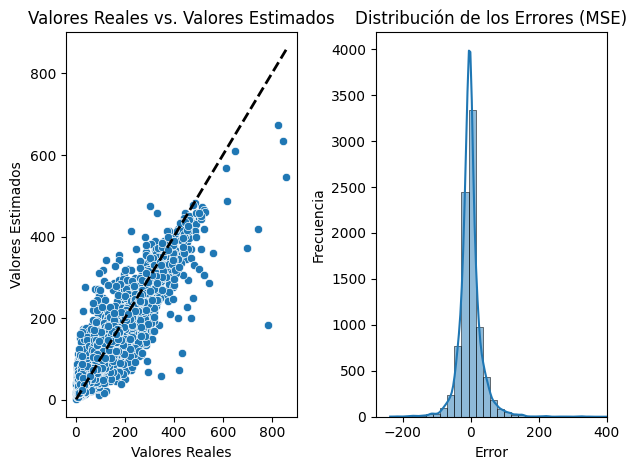

In [56]:
def plot_model(y_test, y_pred):
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Estimados')
    plt.title('Valores Reales vs. Valores Estimados')

    errors = y_test - y_pred
    plt.subplot(1, 2, 2)
    sns.histplot(errors, bins=40, kde=True)
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')
    plt.xlim(right=400)
    plt.title('Distribución de los Errores (MSE)')

    plt.tight_layout()
    plt.show()

plot_model(y_test, y_pred)

In [41]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


def create_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, X_train, y_train, epochs=200, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Neural Network Regression MSE: {mse}')
    print(f'Neural Network Regression R²: {r2}')
    print(f'Neural Network Regression MAE: {mae}')


In [42]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
model = create_model()
history = train_model(model, X_train_scaled, y_train)
evaluate_model(model, X_test_scaled, y_test)

Epoch 1/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7215.6768 - mae: 59.1249 - val_loss: 4672.5557 - val_mae: 47.0603
Epoch 2/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4398.4604 - mae: 45.8107 - val_loss: 4078.8818 - val_mae: 43.2409
Epoch 3/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4347.4722 - mae: 44.9245 - val_loss: 3832.4702 - val_mae: 42.8881
Epoch 4/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4128.5762 - mae: 43.7422 - val_loss: 3881.4045 - val_mae: 41.4539
Epoch 5/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3913.7893 - mae: 42.5456 - val_loss: 3489.1707 - val_mae: 40.8563
Epoch 6/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3832.1248 - mae: 42.0038 - val_loss: 3453.4231 - val_mae: 39.3544
Epoch 7/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3661.0305 - mae: 41.2490 - val_loss: 3380.6328 - val_mae: 39.0708
Epoch 8/200
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3528.7363 - mae: 40.1052 - val_loss: 3371.3757 - v

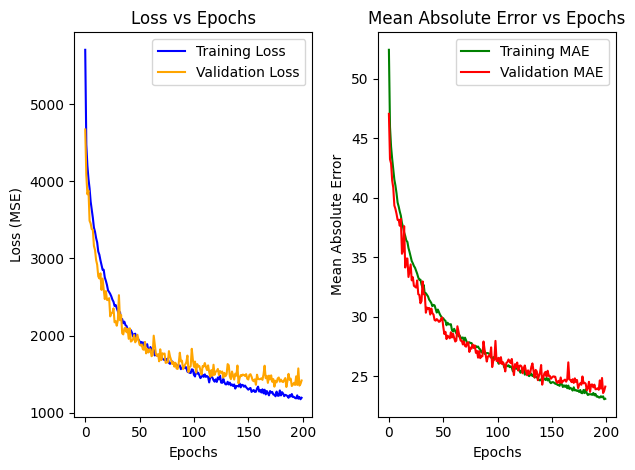

In [43]:
# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.title('Mean Absolute Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 4. Análisis de Resultados de los Modelos entrenados</p>

Debido a los resultados obtenidos con **RandomForest** y **Deep Neural Network**, se optará por el modelo **RandomForest** ya que presenta un mejor rendimiento según sus métricas, como **MSE**, **MAE** y **\( R^2 \)**.

A continuación, se analizan los resultados obtenidos con el modelo **RandomForest**:

1. **Error Cuadrático Medio (MSE)**: 1210.17

   - Este valor representa el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales.

2. **Raíz del Error Cuadrático Medio (RMSE)**: 34.78

   - Esta métrica es más sensible a errores de mayor magnitud. En promedio, las predicciones se desvían del valor real por aproximadamente 35.08 unidades.

3. **Error Absoluto Medio (MAE)**: 21.66

   - Este valor indica que las predicciones del modelo se desvían en promedio 21.90 unidades de los valores reales, lo que puede considerarse un error relativamente bajo.

4. **\( R^2 \) (Coeficiente de Determinación)**: 0.848
   - El \( R^2 \) indica la proporción de la varianza en la variable dependiente (pm2.5) que es predecible a partir de las variables independientes. Un \( R^2 \) de 0.845 sugiere que el modelo explica aproximadamente el 84.5% de la variabilidad de los datos.

# <p style="background-color:hsla(50, 33%, 25%, .75);; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 5. Conclusión</p>

El modelo RandomForest presenta un desempeño sólido, con métricas que indican una buena capacidad de predicción. Esto justifica su elección para la aplicación del modelado. La baja tasa de error, tanto en términos de MSE como de MAE, y el alto valor de R^2 reflejan la efectividad del modelo para capturar la variabilidad en los datos de pm2.5. Además, la robustez de RandomForest frente a overfitting y su capacidad para manejar datos no lineales lo hacen adecuado para este tipo de problemas.


In [ ]:
joblib.dump(rf_model, 'random_forest_model.pkl')